# **06.단순한 1010 패턴**

In [5]:
import torch
import torch.nn as nn

import pandas
import matplotlib.pyplot as plt
import random
import numpy

In [6]:
def generate_real():
    real_data = torch.FloatTensor(
        [random.uniform(0.8, 1.0),
         random.uniform(0.0, 0.2),
         random.uniform(0.8, 1.0),
         random.uniform(0.0, 0.2)])
    return real_data

def generate_random(size):
    random_data = torch.rand(size)
    return random_data


generate_real()


tensor([0.9319, 0.1267, 0.8385, 0.0982])

In [7]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(4, 3),
            nn.Sigmoid(),
            nn.Linear(3, 1),
            nn.Sigmoid()
        )
        
        
        self.loss_function = nn.MSELoss()
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)
        self.counter = 0;
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        outputs = self.forward(inputs)
        loss = self.loss_function(outputs, targets)
        self.counter += 1;

        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass

counter =  10000
counter =  20000


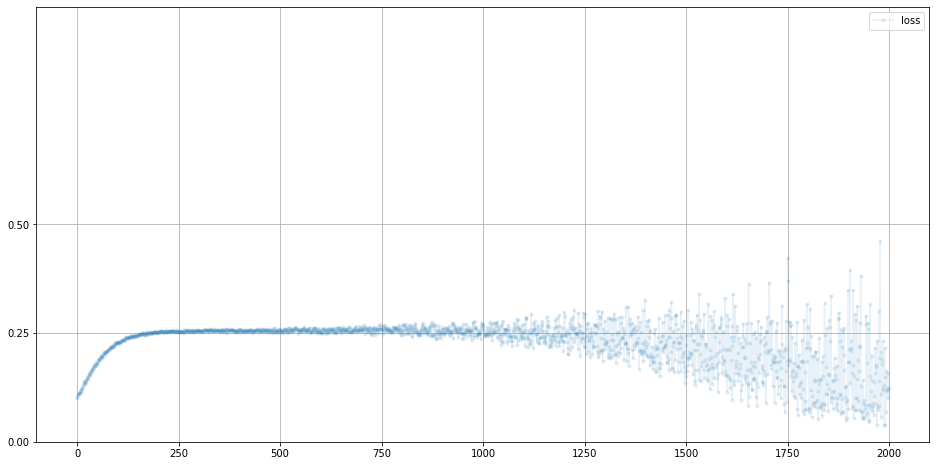

In [8]:
D = Discriminator()

for i in range(10000):
    D.train(generate_real(), torch.FloatTensor([1.0]))
    D.train(generate_random(4), torch.FloatTensor([0.0]))
    pass

D.plot_progress()

In [9]:
print( D.forward( generate_real() ).item() )
print( D.forward( generate_random(4) ).item() )

0.7168443202972412
0.36551138758659363


In [10]:
class Generator(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 3),
            nn.Sigmoid(),
            nn.Linear(3, 4),
            nn.Sigmoid()
        )

        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)
        self.counter = 0;
        self.progress = []
        
        pass
    
    
    def forward(self, inputs):        
        return self.model(inputs)
    
    
    def train(self, D, inputs, targets):
        g_output = self.forward(inputs)
        d_output = D.forward(g_output)

        loss = D.loss_function(d_output, targets)

        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
            
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass

In [11]:
G = Generator()
G.forward(torch.FloatTensor([0.5]))

tensor([0.4301, 0.7101, 0.2580, 0.6290], grad_fn=<SigmoidBackward>)

In [12]:
%%time 

D = Discriminator()
G = Generator()

image_list = []


for i in range(10000):
    
    D.train(generate_real(), torch.FloatTensor([1.0]))
    D.train(G.forward(torch.FloatTensor([0.5])).detach(), torch.FloatTensor([0.0]))

    G.train(D, torch.FloatTensor([0.5]), torch.FloatTensor([1.0]))
    
    if (i % 1000 == 0):
      image_list.append( G.forward(torch.FloatTensor([0.5])).detach().numpy() )

    pass

counter =  10000
counter =  20000
CPU times: user 18.8 s, sys: 41.1 ms, total: 18.8 s
Wall time: 18.7 s


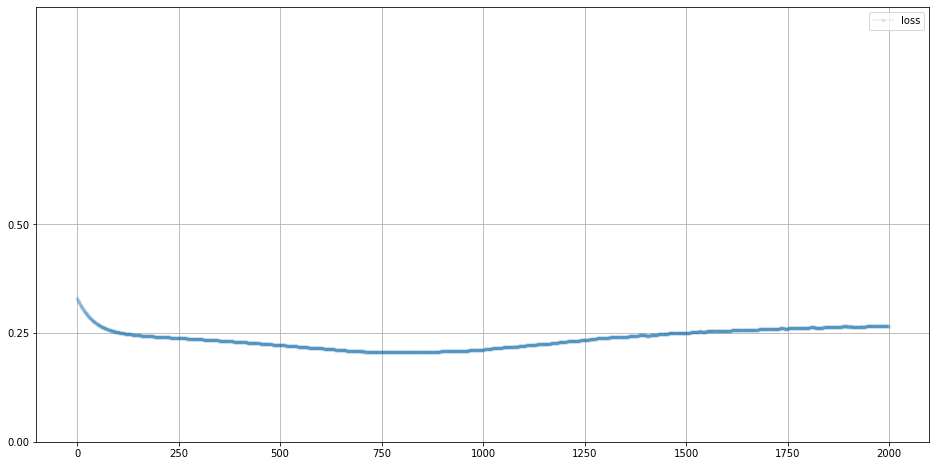

In [13]:
D.plot_progress()

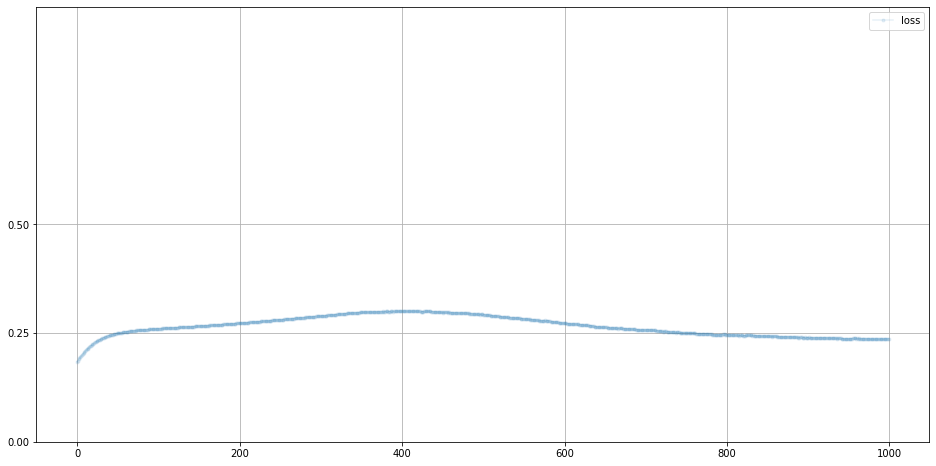

In [14]:
G.plot_progress()


In [15]:
G.forward(torch.FloatTensor([0.5]))

tensor([0.9331, 0.0450, 0.9239, 0.0659], grad_fn=<SigmoidBackward>)

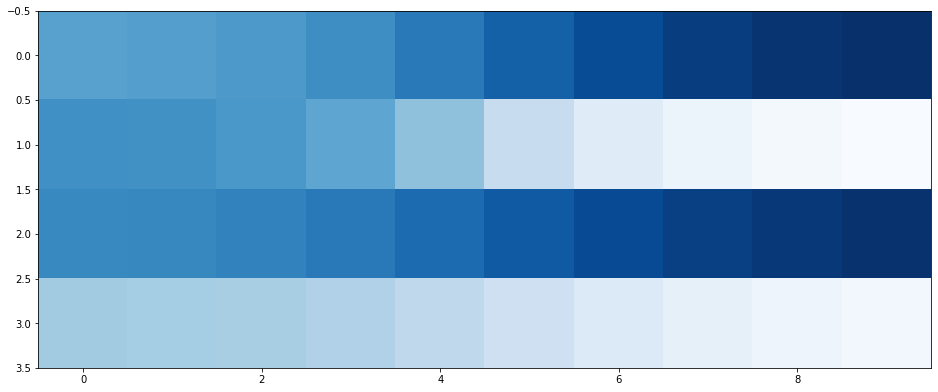

In [16]:
plt.figure(figsize = (16,8))

plt.imshow(numpy.array(image_list).T, interpolation='none', cmap='Blues')

# **07. 손으로 쓴 숫자 훈련**


In [17]:
from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [18]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas, numpy, random
import matplotlib.pyplot as plt

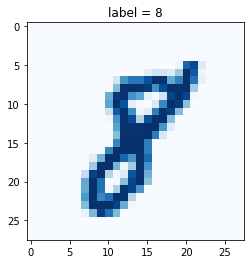

In [21]:

class MnistDataset(Dataset):
    
    def __init__(self, csv_file):
        self.data_df = pandas.read_csv(csv_file, header=None)
        pass
    
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, index):
        label = self.data_df.iloc[index,0]
        target = torch.zeros((10))
        target[label] = 1.0
        image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values) / 255.0
        return label, image_values, target
    
    def plot_image(self, index):
        img = self.data_df.iloc[index,1:].values.reshape(28,28)
        plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(img, interpolation='none', cmap='Blues')
        pass
    
    pass

mnist_dataset = MnistDataset('mount/My Drive/Colab Notebooks/gan_basic/mnist_train.csv')
mnist_dataset.plot_image(17)

In [48]:
def generate_random(size):
    random_data = torch.rand(size)
    return random_data
def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

In [41]:
class Discriminator(nn.Module):
    
    def __init__(self):
       
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 200),
            nn.LeakyReLU(0.02),
            nn.LayerNorm(200),
            nn.Linear(200, 1),
            nn.Sigmoid()
        )

      #  self.model = nn.Sequential(
     #       nn.Linear(784, 200),
      #      nn.Sigmoid(),
      #      nn.Linear(200, 1),
      #      nn.Sigmoid()
      # )


        #self.loss_function = nn.MSELoss()
        self.loss_function = nn.BCELoss()
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.0001)
        self.counter = 0;
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        outputs = self.forward(inputs)
        loss = self.loss_function(outputs, targets)
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [42]:
%%time

D = Discriminator()

for label, image_data_tensor, target_tensor in mnist_dataset:
    D.train(image_data_tensor, torch.FloatTensor([1.0]))
    D.train(generate_random(784), torch.FloatTensor([0.0]))
    pass

counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
CPU times: user 2min 29s, sys: 1.96 s, total: 2min 31s
Wall time: 2min 30s


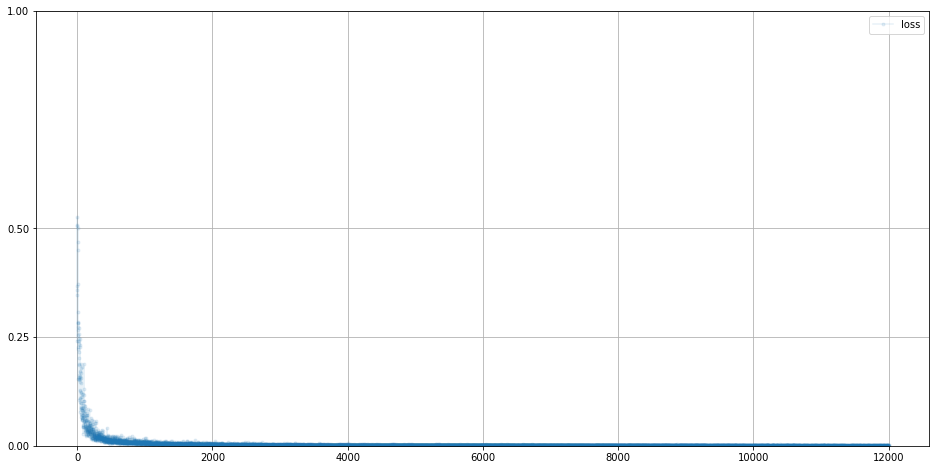

In [43]:
D.plot_progress()

In [45]:
for i in range(4):
  image_data_tensor = mnist_dataset[random.randint(0,60000)][1]
  print( D.forward( image_data_tensor ).item() )
  pass

for i in range(4):
  print( D.forward( generate_random(784) ).item() )
  pass

0.9989584684371948
0.9998316764831543
0.9995288848876953
0.9996041655540466
0.0006807816680520773
0.0006943269399926066
0.0006239607464522123
0.0007204054272733629


In [46]:
class Generator(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 200),
            nn.LeakyReLU(0.02),

            nn.LayerNorm(200),

            nn.Linear(200, 784),
            nn.Sigmoid()
        )

      #  self.model = nn.Sequential(
      #      nn.Linear(1, 200),
      #      nn.Sigmoid(),
      #      nn.Linear(200, 784),
      #      nn.Sigmoid()
      #  )
        
        
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.0001)
        self.counter = 0;
        self.progress = []
        
        pass
    
    
    def forward(self, inputs):        
        return self.model(inputs)
    
    
    def train(self, D, inputs, targets):
        g_output = self.forward(inputs)
        d_output = D.forward(g_output)
 
        loss = D.loss_function(d_output, targets)
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

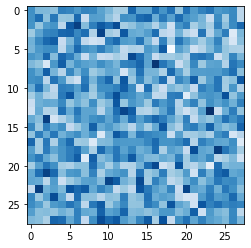

In [49]:
G = Generator()
output = G.forward(generate_random_seed(100))
img = output.detach().numpy().reshape(28,28)

plt.imshow(img, interpolation='none', cmap='Blues')

In [50]:
%%time 
#D = Discriminator()
#G = Generator()
#for label, image_data_tensor, target_tensor in mnist_dataset:
#   D.train(image_data_tensor, torch.FloatTensor([1.0]))
#    D.train(G.forward(generate_random(1)).detach(), torch.FloatTensor([0.0]))
#   G.train(D, generate_random(1), torch.FloatTensor([1.0]))
#  pass

D = Discriminator()
G = Generator()
epochs = 4
for epoch in range(epochs):
  print ("epoch = ", epoch + 1)

  for label, image_data_tensor, target_tensor in mnist_dataset:

    D.train(image_data_tensor, torch.FloatTensor([1.0]))
    D.train(G.forward(generate_random_seed(100)).detach(), torch.FloatTensor([0.0]))
    G.train(D, generate_random_seed(100), torch.FloatTensor([1.0]))
    pass
    
  pass



epoch =  1
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
epoch =  2
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
counter =  190000
counter =  200000
counter =  210000
counter =  220000
counter =  230000
counter =  240000
epoch =  3
counter =  250000
counter =  260000
counter =  270000
counter =  280000
counter =  290000
counter =  300000
counter =  310000
counter =  320000
counter =  330000
counter =  340000
counter =  350000
counter =  360000
epoch =  4
counter =  370000
counter =  380000
counter =  390000
counter =  400000
counter =  410000
counter =  420000
counter =  430000
counter =  440000
counter =  450000
counter =  460000
counter =  470000
counter =  480000
CPU times: user 17min 7s, sys: 14.3 s, total: 17min 21s
Wall time: 17min 18s


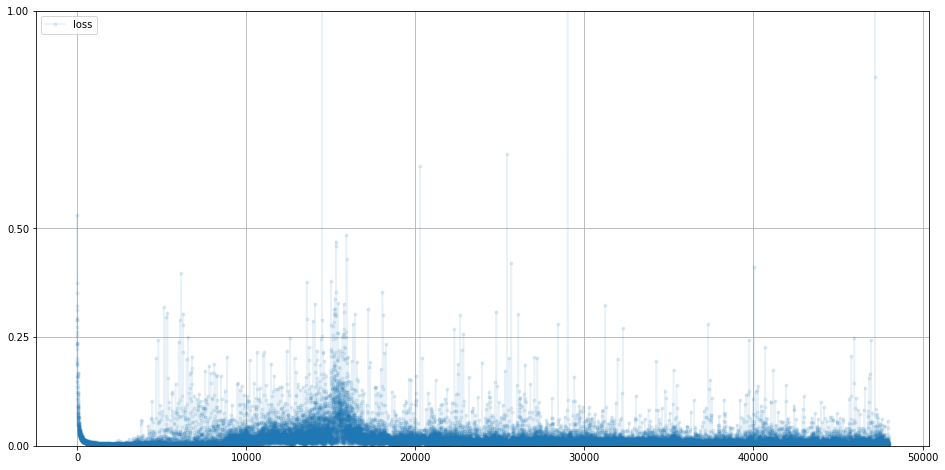

In [51]:
D.plot_progress()

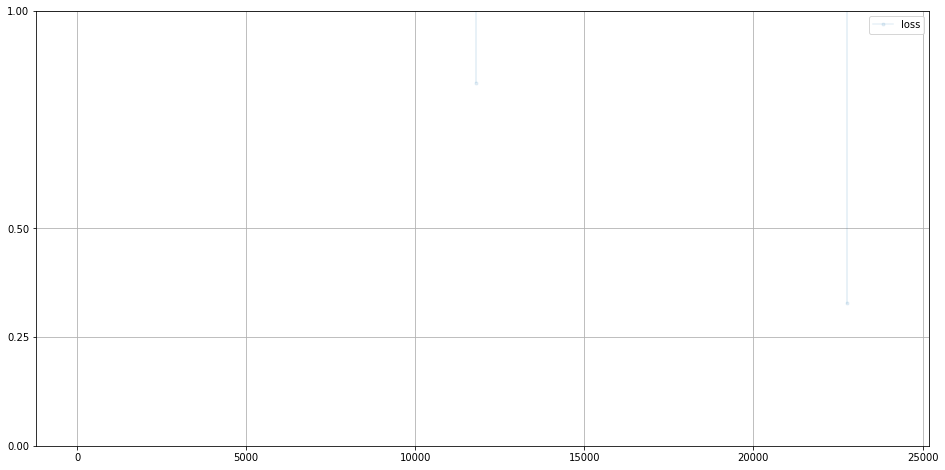

In [52]:
G.plot_progress()

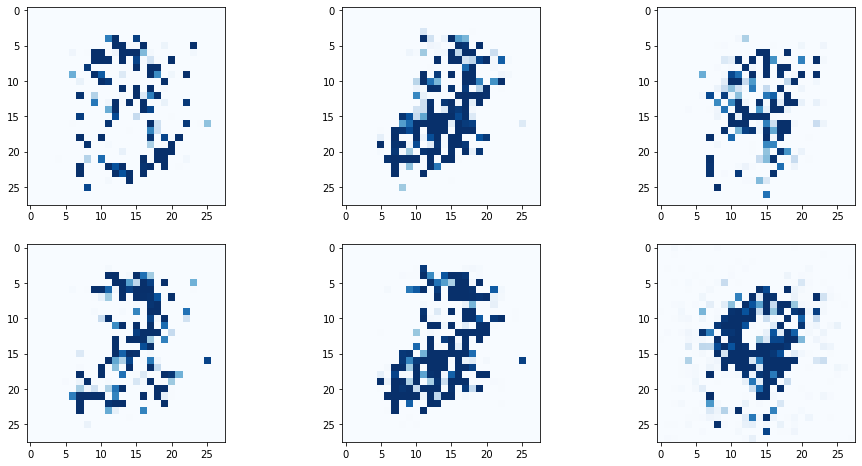

In [53]:
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        #output = G.forward(generate_random(1))
        output = G.forward(generate_random_seed(100))
        img = output.detach().numpy().reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        pass
    pass

# **8 얼굴 이미지**

In [ ]:
import h5py

In [ ]:
class CelebADataset(Dataset):
    
    def __init__(self, file):
        self.file_object = h5py.File(file, 'r')
        self.dataset = self.file_object['img_align_celeba']
        pass
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        if (index >= len(self.dataset)):
          raise IndexError()
        img = numpy.array(self.dataset[str(index)+'.jpg'])
        return torch.cuda.FloatTensor(img) / 255.0
    
    def plot_image(self, index):
        plt.imshow(numpy.array(self.dataset[str(index)+'.jpg']), interpolation='nearest')
        pass
    
    pass

In [ ]:
celeba_dataset = CelebADataset('mount/My Drive/Colab Notebooks/gan_basic/celeba_aligned_small.h5py')

In [ ]:
celeba_dataset.plot_image(43)

In [ ]:
def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data


def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

In [ ]:
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)

In [ ]:
class Discriminator(nn.Module):
    
    def __init__(self):
       
        super().__init__()              
        self.model = nn.Sequential(
            View(218*178*3),
            nn.Linear(3*218*178, 100),
            nn.LeakyReLU(),          
            nn.LayerNorm(100),
            nn.Linear(100, 1),
            nn.Sigmoid()
        )
        
  
        self.loss_function = nn.BCELoss()
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)
        self.counter = 0;
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        outputs = self.forward(inputs)
  
        loss = self.loss_function(outputs, targets)

        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 1000 == 0):
            print("counter = ", self.counter)
            pass

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [ ]:
%%time
D = Discriminator()

D.to(device)

for image_data_tensor in celeba_dataset:
    # real data
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    # fake data
    D.train(generate_random_image((218,178,3)), torch.cuda.FloatTensor([0.0]))
    pass

In [ ]:
D.plot_progress()

In [ ]:
for i in range(4):
  image_data_tensor = celeba_dataset[random.randint(0,20000)]
  print( D.forward( image_data_tensor ).item() )
  pass

for i in range(4):
  print( D.forward( generate_random_image((218,178,3))).item() )
  pass

In [ ]:
class Generator(nn.Module):
    
    def __init__(self):

        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(100, 3*10*10),
            nn.LeakyReLU(),
            
            nn.LayerNorm(3*10*10),
            
            nn.Linear(3*10*10, 3*218*178),
            
            nn.Sigmoid(),
            View((218,178,3))
        )
        
        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        
        pass
    
    
    def forward(self, inputs):        
        # simply run model
        return self.model(inputs)
    
    
    def train(self, D, inputs, targets):

        g_output = self.forward(inputs)
        d_output = D.forward(g_output)

        loss = D.loss_function(d_output, targets)

        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [ ]:

G = Generator()
G.to(device)

output = G.forward(generate_random_seed(100))

img = output.detach().cpu().numpy()

plt.imshow(img, interpolation='none', cmap='Blues')

In [ ]:
%%time 
D = Discriminator()
D.to(device)
G = Generator()
G.to(device)

epochs = 1

for epoch in range(epochs):
  print ("epoch = ", epoch + 1)

  for image_data_tensor in celeba_dataset:
  
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))

    D.train(G.forward(generate_random_seed(100)).detach(), torch.cuda.FloatTensor([0.0]))
    G.train(D, generate_random_seed(100), torch.cuda.FloatTensor([1.0]))

    pass
    
  pass

In [ ]:
D.plot_progress()

In [ ]:
G.plot_progress()

In [ ]:
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(100))
        img = output.detach().cpu().numpy()
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        pass
    pass